<a href="https://colab.research.google.com/github/pletalk/EMPV-RPI-AutoDriving/blob/master/05-DeepPiCar-NVIDIA-AutoLaneFollow-Colab/01-DeepPiCar_AutonomousDriving_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPiCar - OpenCV기반 자동 수집 주행 데이타 기반의 딥러닝 학습 및 주행(Deep Learning Driving)
@2020-08-01/@pletalk

OpenCV기반 자동 수집 주행 데이타(이미지)만으로 모델 학습하기
* 수집된 데이타만으로 학습

* 문서이력
    * 2020-08-01 코드 점검 및 내용 보강
    * 2020-06-22 데이타변형없이 주행데이타만으로 학습
    * 2020-06-14 재검증(OK)
    * 2020-05-24 코드추가하기(이미지로딩, 추가, 학습등)
    * 2020-05-23 처음작성

* [참고자료]
    * [참조 소스코드(DeepPiCar)](https://github.com/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb)
    * [DeepPiCar — Part 5: Autonomous Lane Navigation via Deep Learning](https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110)

<img src="https://miro.medium.com/max/1374/1*p8JiHcvH-wpSxcCzz2r1Sw.jpeg"/>

## [1] DeepPiCar Git코드 다운로드
* 기본 다운로드 디렉토리는 /content/DeepPiCar 디렉토리에 저장

In [54]:
! git clone https://github.com/dctian/DeepPiCar.git

fatal: destination path 'DeepPiCar' already exists and is not an empty directory.


In [55]:
! pwd
! cd DeepPiCar

/content


## [2] 라이브러리 로딩하기

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import logging
import math

import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
from imgaug import augmenters as img_aug
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 2.3.0
keras.__version__: 2.4.3


## [3] OpenCV기반 주행선탐지를 위한 이미지 가져오기
    * directory에 주행을 캡쳐한 이미지들이 있음
    * 로딩을 위한 코드 작성

### 1> 학습할 동영상의 프레임별 이미지 파일 로딩하기

In [58]:
# 데이타를 가져올 디렉토리 설정하기
# 확장자 *.png를 가지는 파일들을 확인할 것
# 파일명의 포맷 -> 이름_순서_각도.png
data_dir = '/content/DeepPiCar/models/lane_navigation/data/images'

### 2> 이미지저장 디렉토리에서 이미지파일 파일 읽어서 분류하기 (경로, 각도)

In [59]:
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

### 3> 파일경로와 각도 리스트 확인하기

In [60]:
image_paths[0:3]

['/content/DeepPiCar/models/lane_navigation/data/images/video01_097_086.png',
 '/content/DeepPiCar/models/lane_navigation/data/images/video01_202_079.png',
 '/content/DeepPiCar/models/lane_navigation/data/images/video01_151_068.png']

In [61]:
steering_angles[0:3]

[86, 79, 68]

In [62]:
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([1.0000, 1.0000, 8.0000, 4.0000, 5.0000, 11.0000, 6.0000, 7.0000,
        26.0000, 2.0000, 10.0000, 21.0000, 18.0000, 23.0000, 15.0000,
        21.0000, 12.0000, 10.0000, 2.0000, 5.0000, 2.0000, 1.0000, 3.0000,
        2.0000, 3.0000]),
 array([44.0000, 46.3600, 48.7200, 51.0800, 53.4400, 55.8000, 58.1600,
        60.5200, 62.8800, 65.2400, 67.6000, 69.9600, 72.3200, 74.6800,
        77.0400, 79.4000, 81.7600, 84.1200, 86.4800, 88.8400, 91.2000,
        93.5600, 95.9200, 98.2800, 100.6400, 103.0000]),
 <a list of 25 Patch objects>)

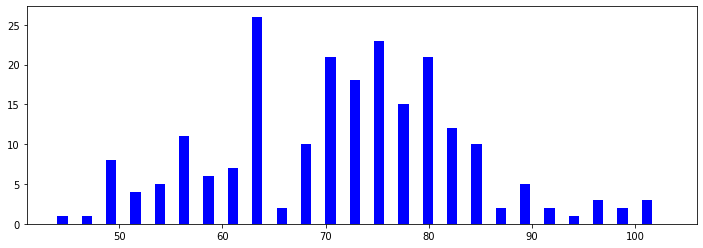

In [63]:
# 주행각도에 대한 분포
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

## [4] 학습데이타와 테스트 데이타 나누기

### 1> train_test_split()를 활용하여 나누기 (비율기반)

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 175
Validation data: 44


In [65]:
type(y_train)

list

In [66]:
type(y_valid)

list

Text(0.5, 1.0, 'Validation Data')

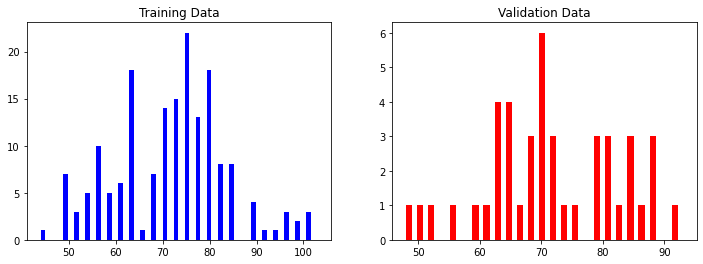

In [67]:
# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

## [5] 이미지 로딩 및 처리 함수들

### 1> 이미지 출력하기

In [68]:
def show_image(image):
    plt.figure(figsize=(8,6))
    plt.imshow(image)

def show_compare_images(src_image, tgt_image):
    nrow=1
    ncol=2
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 6))
    fig.tight_layout()
    axes[0].imshow(src_image)
    axes[1].imshow(tgt_image)

### 2> 이미지 로딩하기

In [69]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### 3> 이미지 로딩 및 출력 테스팅

origin_image_file= /content/DeepPiCar/models/lane_navigation/data/images/video01_015_056.png
origin_steering_angle= 56


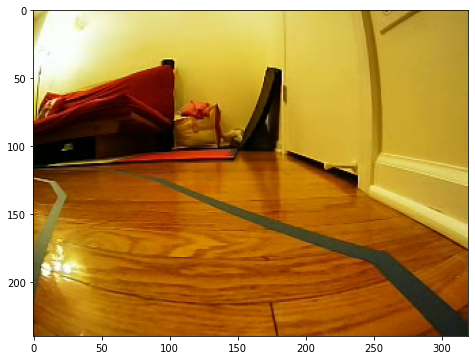

In [70]:
test_sample_index = 0

rgb_image = load_image(X_train[test_sample_index])
steering_angle = y_train[test_sample_index]
print("origin_image_file=",X_train[test_sample_index])
print("origin_steering_angle=",steering_angle)
show_image(rgb_image)

In [71]:
rgb_image.shape

(240, 320, 3)

## [6] 이미지 전처리하기(preprocessing)
* NVIDIA모델의 입력 크기로 변경

### 1> 이미지 전처의 단계별 수행과정 이해
* 이미지의 크기 변경 (높이를 1/2로 변경)

In [72]:
# 이미지의 rgb 차원의 slice값으로 이미지 크기를 변경
height, _, _ = rgb_image.shape
resized_rgb_image = rgb_image[int(height/2):,:,:] 

In [73]:
rgb_image.shape

(240, 320, 3)

In [74]:
resized_rgb_image.shape

(120, 320, 3)

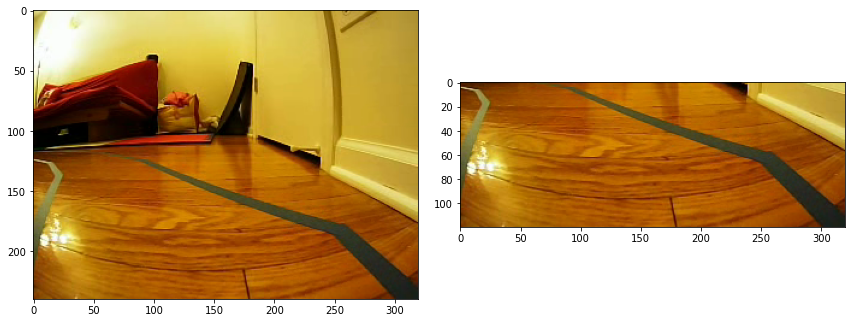

In [75]:
show_compare_images(rgb_image, resized_rgb_image)

### 2> 이미지의 형식변경 (RGB -> YUV)

In [76]:
resized_yuv_image = cv2.cvtColor(resized_rgb_image, cv2.COLOR_RGB2YUV)

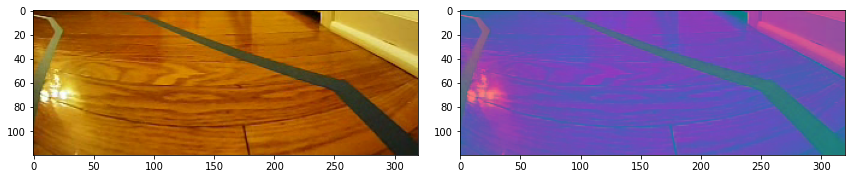

In [77]:
show_compare_images(resized_rgb_image, resized_yuv_image)

### 3> 가우시언블러링 처리(kernel size= 3)

In [78]:
resized_yuv_blurred_image = cv2.GaussianBlur(resized_yuv_image, (3,3), 0)

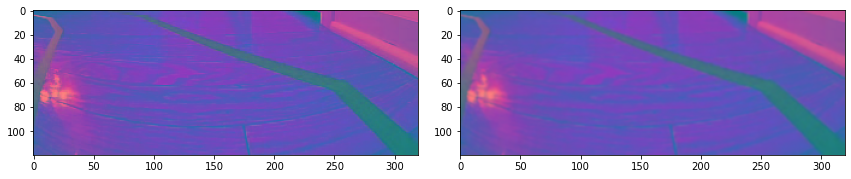

In [79]:
show_compare_images(resized_yuv_image, resized_yuv_blurred_image)

### 4> 이미지 크기 변경 (340x320 -> 66x200)

In [80]:
nvidia_input_image = cv2.resize(resized_yuv_blurred_image, (200,66))

In [81]:
nvidia_input_image.shape

(66, 200, 3)

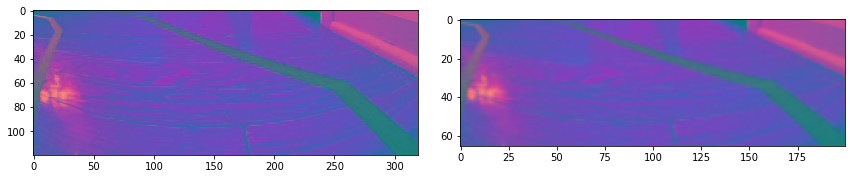

In [82]:
show_compare_images(resized_yuv_image, nvidia_input_image)

### 5> 위의 처리과정의 통합 함수 (img_preprocess)

In [83]:
# 1) 이미지의 포맷을 RGB2YUV로 변경
# 2) GuassianBlur처리를 수행
# 3) 프레임이미지 크기 변경 : 240x320 ->66x200

def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) 
    image = image / 255 
    return image

In [84]:
prep_image = img_preprocess(rgb_image)

In [85]:
prep_image.shape

(66, 200, 3)

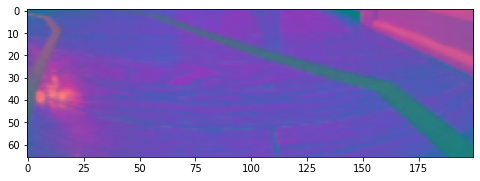

In [86]:
show_image(prep_image)

## [7] NVIDIA 모델 정의하기

### 1> NVIDIA Deep Learning 모델 정의하기

In [87]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

### 2> 모델생성하기 

In [88]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

## [8] NVIDIA 주행 모델 학습하기 

### 1> Tensorboard 설정하기

In [89]:
model_output_dir = '/content/DeepPiCar/models/lane_navigation'
! mkdir '/content/DeepPiCar/models/lane_navigation/logs'

mkdir: cannot create directory ‘/content/DeepPiCar/models/lane_navigation/logs’: File exists


In [90]:
# tensorflow의 수행 로그 저장 디렉토리 설정하기
log_dir_root = f'{model_output_dir}/logs/'
log_dir_root

'/content/DeepPiCar/models/lane_navigation/logs/'

### 2> 학습 및 테스트 데이타 만들기

In [91]:
#
# 학습/테스트 이미지 파일명의 리스트를 입력 받아서 numpy.array()로 변환
#

def merge_images(filepath_list):
    merge_list = []
    for fname in filepath_list:
        # 원래 이미지를 로딩
        trgb_image = load_image(fname)

        # 전처리를 수행
        prep_trgb_image = img_preprocess(trgb_image)
        merge_list.append(prep_trgb_image)
    return np.array(merge_list)

In [92]:
tX_train = merge_images(X_train)
tX_train.shape

(175, 66, 200, 3)

In [93]:
tX_valid = merge_images(X_valid)
tX_valid.shape

(44, 66, 200, 3)

In [97]:
# 2020-08-26일자 추가 
# split함수에서 y_train,y_valid를 List로 반환
# model.fit()에서 np.array를 응답변수로 사용 가능(변환이 필요)
#
y_train = np.ravel(y_train)
y_valid = np.ravel(y_valid)

### 3> NVIDIA주행 학습하기

* Keara모델 기반의 CNN학습과 동일하게 진행

In [99]:
batch_size = 8
epochs = 50

In [100]:
history = model.fit(tX_train,y_train,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data=(tX_valid, y_valid),
                    verbose=1)

Epoch 1/50
22/22 [==============================] - 0s 18ms/step - loss: 1559.3433 - val_loss: 263.1558
Epoch 2/50
22/22 [==============================] - 0s 7ms/step - loss: 169.2741 - val_loss: 105.1903
Epoch 3/50
22/22 [==============================] - 0s 6ms/step - loss: 169.0708 - val_loss: 131.1434
Epoch 4/50
22/22 [==============================] - 0s 6ms/step - loss: 142.1752 - val_loss: 113.6840
Epoch 5/50
22/22 [==============================] - 0s 6ms/step - loss: 154.7774 - val_loss: 123.3097
Epoch 6/50
22/22 [==============================] - 0s 6ms/step - loss: 145.2267 - val_loss: 97.4400
Epoch 7/50
22/22 [==============================] - 0s 5ms/step - loss: 138.3037 - val_loss: 98.8100
Epoch 8/50
22/22 [==============================] - 0s 5ms/step - loss: 141.6364 - val_loss: 96.7625
Epoch 9/50
22/22 [==============================] - 0s 5ms/step - loss: 128.7765 - val_loss: 81.0505
Epoch 10/50
22/22 [==============================] - 0s 5ms/step - loss: 130.1782 - 

### 3> 학습모델 저장하기

In [102]:
# epoch를 반복하면서 저장된 모델값은 _check.h5로 저장 
# 최종적인 학습모델의 값을 저장 

model.save(os.path.join(model_output_dir,'std_lane_navigation_final.h5'))

In [103]:
print("model_output_dir=",model_output_dir)

model_output_dir= /content/DeepPiCar/models/lane_navigation


## [10] 검증하기(validation)

### 1> 학습 및 검증오류 확인하기(그래프)

In [104]:
history.history

{'loss': [1559.34326171875,
  169.2741241455078,
  169.07081604003906,
  142.17523193359375,
  154.7773895263672,
  145.2267303466797,
  138.30369567871094,
  141.6363525390625,
  128.77651977539062,
  130.1781768798828,
  126.42982482910156,
  128.7577667236328,
  105.6398696899414,
  95.9455337524414,
  98.99535369873047,
  93.09693908691406,
  62.03367233276367,
  70.49382781982422,
  84.79218292236328,
  59.22190856933594,
  58.854061126708984,
  51.641265869140625,
  56.94261169433594,
  51.13603973388672,
  47.95711898803711,
  39.079345703125,
  44.07093048095703,
  41.26115036010742,
  40.213905334472656,
  36.9393424987793,
  39.348045349121094,
  40.8884162902832,
  33.49147415161133,
  33.25843048095703,
  32.55241775512695,
  31.832223892211914,
  29.084646224975586,
  27.673892974853516,
  31.54624366760254,
  22.659568786621094,
  20.013452529907227,
  27.956838607788086,
  30.12274742126465,
  21.75511932373047,
  27.465566635131836,
  20.891551971435547,
  14.8157844543

In [105]:
# 학습데이타의 손실/epoch
history.history['loss']

[1559.34326171875,
 169.2741241455078,
 169.07081604003906,
 142.17523193359375,
 154.7773895263672,
 145.2267303466797,
 138.30369567871094,
 141.6363525390625,
 128.77651977539062,
 130.1781768798828,
 126.42982482910156,
 128.7577667236328,
 105.6398696899414,
 95.9455337524414,
 98.99535369873047,
 93.09693908691406,
 62.03367233276367,
 70.49382781982422,
 84.79218292236328,
 59.22190856933594,
 58.854061126708984,
 51.641265869140625,
 56.94261169433594,
 51.13603973388672,
 47.95711898803711,
 39.079345703125,
 44.07093048095703,
 41.26115036010742,
 40.213905334472656,
 36.9393424987793,
 39.348045349121094,
 40.8884162902832,
 33.49147415161133,
 33.25843048095703,
 32.55241775512695,
 31.832223892211914,
 29.084646224975586,
 27.673892974853516,
 31.54624366760254,
 22.659568786621094,
 20.013452529907227,
 27.956838607788086,
 30.12274742126465,
 21.75511932373047,
 27.465566635131836,
 20.891551971435547,
 14.815784454345703,
 17.44743537902832,
 18.97844886779785,
 17.2677

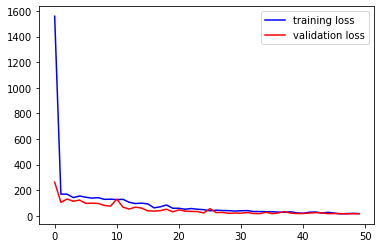

In [106]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

### 2> 학습모델 로딩 및 검증결과 출력하기

In [107]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/std_lane_navigation_final.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

### 3> 검증결과 출력하기

In [108]:
y_pred = predict_and_summarize(tX_valid, y_valid)

mse       = 1.6e+01
r_squared = 85.71%



### 4> 검증결과 이미지출력하기 

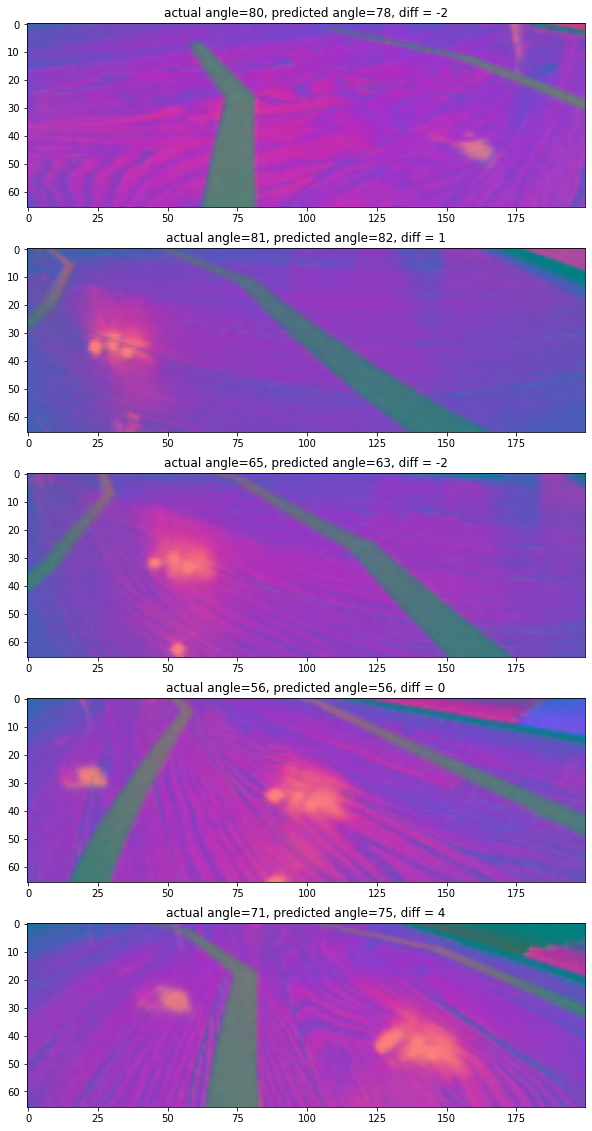

In [109]:
n_tests_show = 5
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(tX_valid[i+5])
    axes[i].set_title(f"actual angle={y_valid[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_valid[i]}")

## [11] 학슴모델 로딩 및 파라미터 확인하기

In [110]:
from tensorflow import keras

model_path = os.path.join(model_output_dir,'std_lane_navigation_final.h5')
print(model_path)

/content/DeepPiCar/models/lane_navigation/std_lane_navigation_final.h5


In [111]:
# keras model 로딩하기
loaded_model = keras.models.load_model(model_path)

In [112]:
#dir(loaded_model)

In [113]:
to_json = loaded_model.to_json()
print(to_json)

{"class_name": "Sequential", "config": {"name": "Nvidia_Model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 66, 200, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_5_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_5", "trainable": true, "batch_input_shape": [null, 66, 200, 3], "dtype": "float32", "filters": 24, "kernel_size": [5, 5], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "elu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Conv2D", "config": {"name": "conv2d_6", "trainable": true, "dtype": "float32", "filters": 36, "kernel_size": [5, 5], "strides": [2, 2], "padding":

In [114]:
import pprint
import json

In [115]:
pp = pprint.PrettyPrinter()
pp.pprint(json.loads(to_json))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': {'layers': [{'class_name': 'InputLayer',
                        'config': {'batch_input_shape': [None, 66, 200, 3],
                                   'dtype': 'float32',
                                   'name': 'conv2d_5_input',
                                   'ragged': False,
                                   'sparse': False}},
                       {'class_name': 'Conv2D',
                        'config': {'activation': 'elu',
                                   'activity_regularizer': None,
                                   'batch_input_shape': [None, 66, 200, 3],
                                   'bias_constraint': None,
                                   'bias_initializer': {'class_name': 'Zeros',
                                                        'config': {}},
                                   'bias_regularizer': None,
                                   'data_format': 'channels_last',
            